Author: Minghao Liu

UNI: ml5312

Date: 12/14/2025

Course: EECS E4040 - Deep Learning & Neural Networks

Note: We wrote this code ourselves, except where we have clearly mentioned references or collaborations.

References :
A. Trockman and J. Z. Kolter, “Patches are all you need?,” arXiv preprint, arXiv:2201.09792, 2022.

# 02 - ConvMixer Training on CIFAR-10

This notebook trains ConvMixer on CIFAR-10 and verifies the training pipeline works.

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.models.convmixer import ConvMixer, count_parameters

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Loading (Basic transforms for now)

In [2]:
# Basic transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

print(f"Training batches: {len(trainloader)}")
print(f"Test batches: {len(testloader)}")

Files already downloaded and verified
Files already downloaded and verified
Training batches: 782
Test batches: 100


## 2. Create Model

In [3]:
# Create a smaller ConvMixer for quick testing
# We'll use a lighter config first to verify everything works
model = ConvMixer(
    dim=256,
    depth=8,
    kernel_size=7,
    patch_size=4,  # Larger patch = faster training
    num_classes=10
).to(device)

print(f"Model: ConvMixer-256/8 (k=7, p=4)")
print(f"Parameters: {count_parameters(model):,}")

Model: ConvMixer-256/8 (k=7, p=4)
Parameters: 652,554


## 3. Training Setup

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training history
history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

## 4. Training Loop (Quick Test - 5 epochs)

In [5]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

In [6]:
# Quick training test - just 5 epochs to verify everything works
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    test_acc = evaluate(model, testloader, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Acc: {test_acc:.2f}%")

Training: 100%|██████████| 782/782 [00:23<00:00, 33.21it/s]


Epoch 1/5
  Train Loss: 1.4610, Train Acc: 46.96%
  Test Acc: 58.30%


Training: 100%|██████████| 782/782 [00:23<00:00, 33.22it/s]


Epoch 2/5
  Train Loss: 1.0877, Train Acc: 61.19%
  Test Acc: 66.59%


Training: 100%|██████████| 782/782 [00:23<00:00, 33.28it/s]


Epoch 3/5
  Train Loss: 0.9123, Train Acc: 67.69%
  Test Acc: 71.86%


Training: 100%|██████████| 782/782 [00:24<00:00, 32.47it/s]


Epoch 4/5
  Train Loss: 0.7867, Train Acc: 72.40%
  Test Acc: 75.11%


Training: 100%|██████████| 782/782 [00:24<00:00, 32.10it/s]


Epoch 5/5
  Train Loss: 0.7000, Train Acc: 75.59%
  Test Acc: 75.47%


## 5. Plot Training Curves

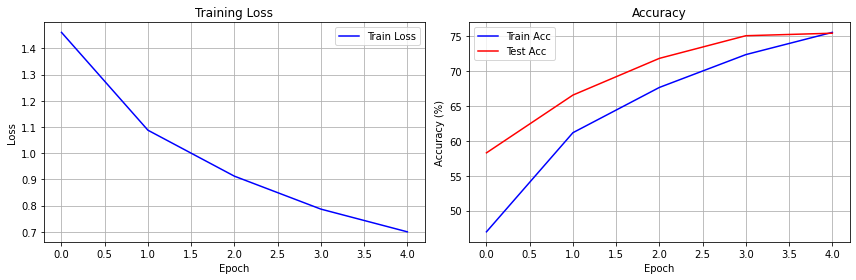

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['train_loss'], 'b-', label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], 'b-', label='Train Acc')
axes[1].plot(history['test_acc'], 'r-', label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../figures/convmixer_quick_train.png', dpi=150)
plt.show()

## Summary

- ConvMixer training pipeline verified
- Model is learning (loss decreasing, accuracy increasing)
- Ready for full training with proper hyperparameters